<a href="https://colab.research.google.com/github/AnupamaRajkumar/PyTorchTutorials/blob/main/ClassificationUsingCIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install torch torchvision

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

Pooling : Maxpooling gives scale invariant representation of the image and is not affected by small translations and rotations and hence generalises the model well

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

In [4]:
#data augmentation
transform_train = transforms.Compose([transforms.Resize((32,32)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                    ])

transform = transforms.Compose([transforms.Resize((32,32)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])
training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [5]:
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)

In [6]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0) #shape 32 x 32 x 1
  #de-normalisation - multiply by std and add mean
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

classes of CIFAR 10 dataset

In [7]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

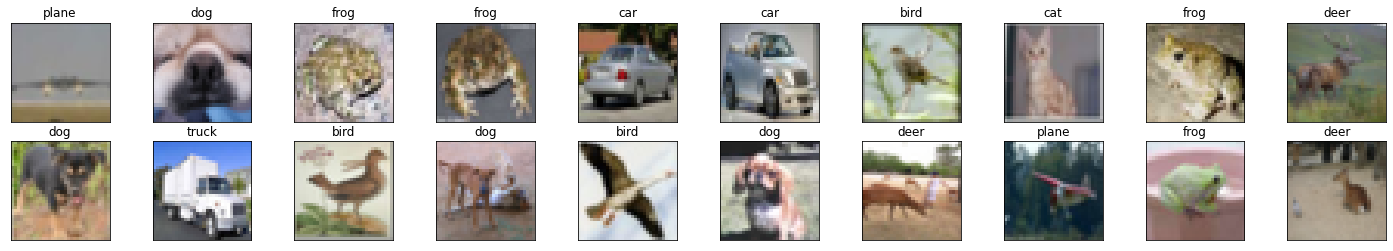

In [8]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25,4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  #print(labels[idx].item())
  ax.set_title(classes[labels[idx].item()])

Test 1: Train LeNET model from MNIST to check how it performs with CIFAR

Adding padding so that the output after convolution is same as that of input\
Hence, dimension of fc1 is calculated as:\
1. conv1 = 32x32x16
2. pool1 = 16x16x16
3. conv2 = 16x16x32
4. pool2 = 8x8x32
5. conv3 = 8x8x64
6. pool3 = 4x4x64
7. fc1 = 4x4x64

In [9]:
class LeNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, 3, 1, padding = 1)    #number of input channels, number of output channels, kernel size, stride length
    self.conv2 = nn.Conv2d(16, 32, 3, 1, padding = 1)
    self.conv3 = nn.Conv2d(32, 64, 3, 1, padding = 1)
    self.fc1 = nn.Linear(4*4*64, 500)
    self.drop1 = nn.Dropout(0.5)                  #dropout to prevent overfitting
    self.fc2 = nn.Linear(500, 10)


  def forward(self, x):
    L1 = F.relu(self.conv1(x))
    P1 = F.max_pool2d(L1, 2, 2)
    L2 = F.relu(self.conv2(P1))
    P2 = F.max_pool2d(L2, 2, 2)
    L3 = F.relu(self.conv3(P2))
    P3 = F.max_pool2d(L3, 2, 2)
    fi = P3.view(-1, 4*4*64)
    f1 = F.relu(self.fc1(fi))
    d1 = self.drop1(f1)
    #we can omit softmax here since we will use crossentropy as loss criterion
    #and it's implementation in pytorch already implements softmax
    f2  = self.fc2(d1)
    return f2

In [10]:
model = LeNet().to(device) 
model

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (drop1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [12]:
epochs = 15
losses = []
accuracy = []
val_losses = []
val_accuracies = []

for e in range(epochs):
  running_loss = 0.0
  running_accuracy = 0.0
  val_loss = 0.0
  val_accuracy = 0.0

  for images, labels in training_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)   
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, preds = torch.max(outputs, 1)
    running_accuracy += torch.sum(preds == labels.data)
    running_loss += loss.item() 

  else:
    with torch.no_grad():       #because we dont have to perform gradients for validation set
      for val_images, val_labels in validation_loader:
        val_images = val_images.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_images)
        val_loss = criterion(val_outputs, val_labels)

        _, val_preds = torch.max(val_outputs, 1)
        val_accuracy += torch.sum(val_preds == val_labels.data)
        val_loss += val_loss.item() 
    #metrics for training data
    epoch_loss = running_loss/len(training_loader)
    epoch_accuracy = running_accuracy.float()/len(training_loader)
    losses.append(epoch_loss)
    accuracy.append(epoch_accuracy)
    #metrics for validation data
    val_epoch_loss = val_loss/len(validation_loader)
    val_epoch_accuracy = val_accuracy.float()/len(validation_loader)
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_accuracy)
    #print the training and validation metrics
    print("epoch:", e+1)
    print('training loss: {:.6f}, acc {:.6f}'.format(epoch_loss, epoch_accuracy.item()))
    print('validation loss: {:.6f}, acc {:.6f}'.format(val_epoch_loss, val_epoch_accuracy.item()))

epoch: 1
training loss: 1.561552, acc 43.078003
validation loss: 0.025828, acc 53.719997
epoch: 2
training loss: 1.200550, acc 57.102001
validation loss: 0.022482, acc 61.020000
epoch: 3
training loss: 1.023099, acc 63.884003
validation loss: 0.022648, acc 64.510002
epoch: 4
training loss: 0.914722, acc 67.768005
validation loss: 0.020570, acc 66.489998
epoch: 5
training loss: 0.832326, acc 70.746002
validation loss: 0.019713, acc 69.260002
epoch: 6
training loss: 0.768143, acc 72.786003
validation loss: 0.017787, acc 70.239998
epoch: 7
training loss: 0.706700, acc 75.060005
validation loss: 0.018292, acc 70.409996
epoch: 8
training loss: 0.664471, acc 76.536003
validation loss: 0.019897, acc 71.339996
epoch: 9
training loss: 0.618620, acc 78.306007
validation loss: 0.021456, acc 70.729996
epoch: 10
training loss: 0.576234, acc 79.632004
validation loss: 0.018147, acc 72.260002
epoch: 11
training loss: 0.548534, acc 80.584007
validation loss: 0.020209, acc 72.260002
epoch: 12
training 

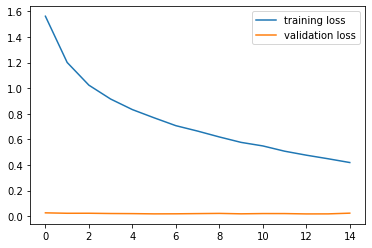

In [13]:
plt.plot(losses, label='training loss')
plt.plot(val_losses, label='validation loss')
plt.legend()

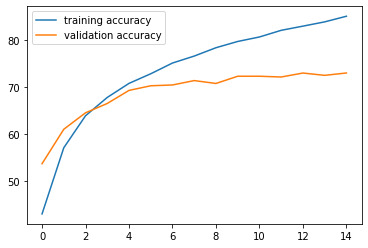

In [14]:
plt.plot(accuracy, label='training accuracy')
plt.plot(val_accuracies, label = 'validation accuracy')
plt.legend()

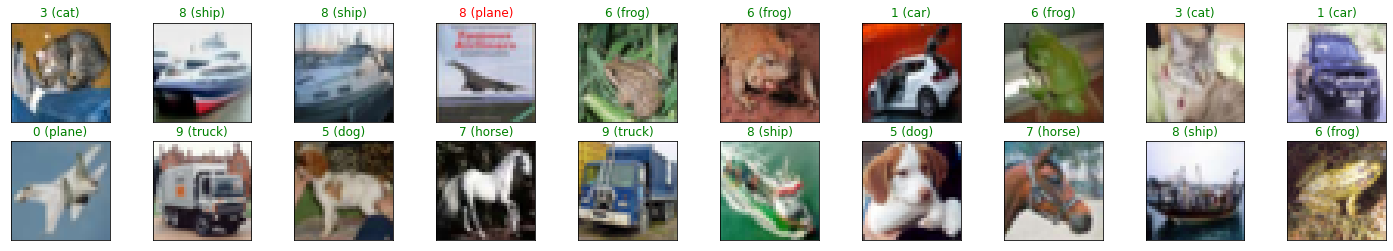

In [17]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(preds[idx].item()), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))